# Data Science and Artificial Intelligence II

## Fake News detection project

### by David Sitek and Nicola Krenn

Welcome to our little project on Fake News detection using tree-based models specifically, mainly because of their possibly more natural explanative value. In the following steps, we will prepare the data as input for the models, then extract features and build the models. The dataset used can be viewed under the link below, it is an updated version of the dataset used in:

Ahmed, H., Traore, I., Saad, S. (2017). Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore, I., Woungang, I., Awad, A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science(), vol 10618. Springer, Cham. https://doi.org/10.1007/978-3-319-69155-8_9

The general goal as proposed is to get better insights in why the authors in the study did not pursue tree-based models, as their tree-based model did not score much worse than the possibly less explainable models. We hope to explore a bit around the topic as well.

In [ ]:
#!wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip

In [ ]:
#!unzip -o News-_dataset.zip

The two input files Fake.csv and True.csv contain exactly that, true and fake articles. A tabular overview is provided along the dataset:

![Picture title](image-20230523-123159.png)

For our task we rely mainly on in-memory analytics star pandas along with some ML/AI libraries for the models

In [ ]:
import pandas as pd

In [ ]:
df_fake = pd.read_csv("Fake.csv")

In [ ]:
df_fake

You can see that the original dataset features 4 columns, including the title and the type as well as the date. For our use-case, we mainly rely on the full-text rather than the title. One might argue that the title itself contains valuable information, however, we think that out-of-context lurid phrases like the title might even be misleading in some more quality-oriented journalism. Therefore, we will remove this later on, but keep it right now for context.

In [ ]:
df_fake["fake"] = True

In [ ]:
df_fake

In [ ]:
df_non_fake = pd.read_csv("True.csv")

In [ ]:
df_non_fake["fake"] = False

In [ ]:
df = pd.concat([df_non_fake, df_fake])

In [ ]:
df

In [ ]:
df.describe()

Upon checking the data, what quickly comes to mind is that there seemingly are a lot of duplicates regarding the text. Since duplicates in general might skew results and in general do not add much value, we will look into this first, possibly spotting also other interesting points.

In [ ]:
df[df["text"].duplicated()].sort_values(by="text")

Two things become visible especially, one being that many columns are empty and that there are a lot of texts just containing a click-bait title and a link, for example a youtube link. Since we cannot really check the links content and would just need to be checking the title, and the general use-case example is not really focused on click-bait media, we should probably remove this. This could be handled by e.g. either removing link-only articles or by enforcing a lower bound for article length.

In [ ]:
df["text_length"] = df["text"].apply(len)

In [ ]:
df["text_length"].describe()

When looking at the general distribution of the text length, it seems obvious that there are in general just very few low length articles. We decided that cutting all articles with a length lower than 100 seems like a good idea, as they will probably just reference to some other resource.

In [ ]:
df = df[df["text_length"] >= 100]

In [ ]:
df

We started with 44898 rows, now there are only 43858 left. Seems reasonable. Let us now look at the rest of the "duplicates".

In [ ]:
df[df["text"].duplicated(keep=False)].sort_values(by="text")

We can see that we reduced the duplicates already, however, still having a lot of duplicates by text. The smartest thing to do here is to deduplicate it. Pandas Dataframe.drop_duplicates(keep=first) keeps the first occurrence of the duplicate.df

In [ ]:
df_cleaned = df.drop_duplicates(subset="text", keep="first")

In [ ]:
df_cleaned["text"].duplicated().sum()

In [ ]:
df_cleaned[df_cleaned["fake"] == True].count()

In [ ]:
df_cleaned[df_cleaned["fake"] == False].count()

In [ ]:
df_cleaned[df_cleaned["fake"] == False].groupby(by="subject").count()

In [ ]:
df_cleaned[df_cleaned["fake"] == True].groupby(by="subject").count()

In [ ]:
# Transform "fake" labels to fake = 1, not-fake = 0
df_cleaned["fake"] = df_cleaned["fake"].replace(to_replace=False, value=0)
df_cleaned["fake"] = df_cleaned["fake"].replace(to_replace=True, value=1)

In [ ]:
df_cleaned

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df_cleaned['text'], df_cleaned['fake'], test_size=0.2, random_state=15)

# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000)
train_features = vectorizer.fit_transform(train_data)
test_features = vectorizer.transform(test_data)

# Train a decision tree classifier
tree_model = DecisionTreeClassifier()
tree_model.fit(train_features, train_labels)

# Extract feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Visualize the decision tree
tree.plot_tree(tree_model, feature_names=feature_names)

# Get the most important features for classification
importance = tree_model.feature_importances_
important_features = [(feature_names[i], importance[i]) for i in range(len(feature_names))]
important_features.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 important features
print("Top 10 important features:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance}")


In [ ]:
train_data

The first run seems quite successful. However, we see that the top most important feature is "reuters". You can see that in some cases "reuters" is written in the beginning of the text. Since the dataset under study sourced most of its "true" articles from reuters, this should be no real surprise. We will probably have to remove this... However, let's just see how this tree model did.

In [ ]:
pred = tree_model.predict(test_features)

In [ ]:
import numpy as np

In [ ]:
print("RMS: %r " % np.sqrt(np.mean((pred - test_labels) ** 2)))

In [ ]:
loc_test_labels = test_labels.reset_index()
sum_correct = 0
for i in range(0, len(pred)-1):
    if pred[i] == loc_test_labels["fake"][i]:
        sum_correct += 1
        

In [ ]:
sum_correct

In [ ]:
len(pred)

In [ ]:
sum_correct / len(pred) # 99.5% items predicted positively in total

It appears that this way of predicting is almost 100% successful, no wonder because of the reuters keyword. One may wonder if the authors of the study did or did not remove this in the course of their paper. The fact that this is still in the dataset is a key demonstrator for the use of explainable models in general, because in a study with biased data and a non-explainable model, we would have never stumbled upon this. In general, this happens frequently in research as well as in industry, leading to multiple consequences.

Because the keyword is in the data, we want to remove it first, but let us have a little overview in what the previous network implemented feature-wise. In the main study for reference (see below), they used stop-word removal, stemming and TF-IDF vectorizing in order to get to their depicted accuracy of models. The model above only implements the TF-IDF vectorizing aspect.

So for a next step, we will first remove the reuters keyword naively, so cutting "(Reuters)", and similar texts is next up. Then we rerun the same model with only the TF-IDF vectorizer and compare.

In [ ]:
df_cleaned

In [ ]:
df_cleaned["text"] = df_cleaned["text"].map(lambda x: x.replace("(Reuters)", ""))

In [ ]:
df_cleaned["text"] = df_cleaned["text"].map(lambda x: x.replace("Reuters", ""))

In [ ]:
df_cleaned["text"] = df_cleaned["text"].map(lambda x: x.replace("reuters", ""))

In [ ]:
df_cleaned

As a little heads-up: we removed the key reuters, however, there still is the location mentioned first in most of the reuters articles. We will see if the locations now get flagged as truthful high important features...

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df_cleaned['text'], df_cleaned['fake'], test_size=0.2, random_state=15)

# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000)
train_features = vectorizer.fit_transform(train_data)
test_features = vectorizer.transform(test_data)

# Train a decision tree classifier
tree_model = DecisionTreeClassifier()
tree_model.fit(train_features, train_labels)

# Extract feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Visualize the decision tree
tree.plot_tree(tree_model, feature_names=feature_names)

# Get the most important features for classification
importance = tree_model.feature_importances_
important_features = [(feature_names[i], importance[i]) for i in range(len(feature_names))]
important_features.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 important features
print("Top 10 important features:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance}")


In [ ]:
pred = tree_model.predict(test_features)

loc_test_labels = test_labels.reset_index()
sum_correct = 0
for i in range(0, len(pred)-1):
    if pred[i] == loc_test_labels["fake"][i]:
        sum_correct += 1


sum_correct / len(pred) # 93.5% items predicted positively in total

The inbetween model not containing the Reuters keyword anymore seems to have a new champion in important features. The word "via". We will quickly look into this manually and check wether it is used in some sense that is far off from the use-case comparably like "reuters". 

In [ ]:
df.iloc[5,1]

In [ ]:
df[df['text'].str.contains(' via ')]["text"].iloc[10]

From manual inspection, we did not find any clues to this when looking at the uncleaned text. So it probably is just used as a normal word and fake news do not like it (as it might be used as a word to establish proof/references). What is interesting is that the location like Beijing in the above example does not play a role.

In [ ]:
df_cleaned["text"]

We think that from a data cleaning standpoint, this dataset is now quite solid, especially since we removed the indicator reuters. The next thing to do is to move on to feature selection, specifically applying the methods used in the paper, which we will quickly list and explain here:

Stop Word Removal:

Insignificant words like about, that, ... may create noise in such models like we have here. They are commonly used and can especially be "noisy" when using n-Gram type of analysis. In the paper, they stated that they "removed common words
such as, a, about, an, are, as, at, be, by, for, from, how, in, is, of, on, or, that, the, these,
this, too, was, what, when, where, who, will, etc.".

As this list is not very specific and we do not have the code they used (although asking for it via e-mail), we might as well just rely on the preselected list of stopwords from scikit. The option stop_words = 'english' uses the prebuilt list.

The following code will rerun the model above with just this addition in order to compare and contrast the change.

In [ ]:
# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df_cleaned['text'], df_cleaned['fake'], test_size=0.2, random_state=15)

# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
train_features = vectorizer.fit_transform(train_data)
test_features = vectorizer.transform(test_data)

# Train a decision tree classifier
tree_model = DecisionTreeClassifier()
tree_model.fit(train_features, train_labels)

# Extract feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Visualize the decision tree
tree.plot_tree(tree_model, feature_names=feature_names)

# Get the most important features for classification
importance = tree_model.feature_importances_
important_features = [(feature_names[i], importance[i]) for i in range(len(feature_names))]
important_features.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 important features
print("Top 10 important features:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance}")


In [ ]:
pred = tree_model.predict(test_features)

loc_test_labels = test_labels.reset_index()
sum_correct = 0
for i in range(0, len(pred)-1):
    if pred[i] == loc_test_labels["fake"][i]:
        sum_correct += 1


sum_correct / len(pred) # 92.6% items predicted positively in total

In a trial and error fashion, we found that just applying stop word removal lowers the accuracy by around a full percent, leading to the "via" feature to disappear. Upon looking it up, it really is marked as a stop-word. We accept this for now, moving on to other techniques. As a little heads-up: we looked at literature regarding text pre-processing and found the following graphic representation of mostly used text pre-processing techniques from https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8

![Picture title](image-20230602-091356.png)

Note that the paper in general uses some of the older examples, however, does not mention noise removal or some more advanced techniques like Lemmatization.

Moving on to the next step in the paper, they use stemming, specifically the "porter stemmer", which they mention to be the most commonly used stemming algorithm due to its accuracy (at the time of writing!). The NLTK package offers a stemmer also applying the porter algorithm. We will use this.

In [ ]:
from nltk.stem.porter import *

stemmer = PorterStemmer()

df_cleaned["text_stemmed"] = df_cleaned['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))


In [ ]:
df_cleaned["text"].iloc[1]

In [ ]:
df_cleaned["text_stemmed"].iloc[1]

In [ ]:
# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df_cleaned['text_stemmed'], df_cleaned['fake'], test_size=0.2, random_state=15)

# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
train_features = vectorizer.fit_transform(train_data)
test_features = vectorizer.transform(test_data)

# Train a decision tree classifier
tree_model = DecisionTreeClassifier()
tree_model.fit(train_features, train_labels)

# Extract feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Visualize the decision tree
tree.plot_tree(tree_model, feature_names=feature_names)

# Get the most important features for classification
importance = tree_model.feature_importances_
important_features = [(feature_names[i], importance[i]) for i in range(len(feature_names))]
important_features.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 important features
print("Top 10 important features:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance}")


In [ ]:
pred = tree_model.predict(test_features)

loc_test_labels = test_labels.reset_index()
sum_correct = 0
for i in range(0, len(pred)-1):
    if pred[i] == loc_test_labels["fake"][i]:
        sum_correct += 1


sum_correct / len(pred) # 94.9% items predicted positively in total

The resulting stemmed column will now be used as input for the TFIDF Vectorizer and the model in general. You can see the new model and accuracy above. Please note that because of the stemming, we had to move to a different, more powerful machine, since this takes much resources. This may or may not make it unviable for you to run the notebook on your machine.

Next up, the paper incorporates a 5-fold cross validation. This ensures that the results are stable. We will incorporate this down here.

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df_cleaned["text_stemmed"])
y = df_cleaned["fake"]

# Train a decision tree classifier using 5-fold-cross-validation
tree_model = DecisionTreeClassifier()
scores = cross_val_score(tree_model, X, y, cv=5)

# Print the cross-validation accuracy scores
print("Cross-Validation Accuracy Scores:")
for fold, score in enumerate(scores, start=1):
    print(f"Fold {fold}: {score}")

In [ ]:
scores.mean()

We can see that the average accuracy dropped a little bit, however, it still stays pretty high. As a first reference to the studies results, the "highest" achieved Accuracy usingn Decision trees was achieved by using TF-IDF in a Unigram setting. It was 89.0 percent. This means that our model scores significantly better than the model in the study, while not even setting the maximum features to higher values or tweaking additional hyperparameters. The two decision tree models that scored best were the ones using 10 thousand and 50 thousand maximum features. Therefore, we suggest testing this next, also applying a k-fold validation.

In [ ]:
# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X = vectorizer.fit_transform(df_cleaned["text_stemmed"])
y = df_cleaned["fake"]

# Train a decision tree classifier using 5-fold-cross-validation
tree_model = DecisionTreeClassifier()
scores = cross_val_score(tree_model, X, y, cv=5)

# Print the cross-validation accuracy scores
print("Cross-Validation Accuracy Scores:")
for fold, score in enumerate(scores, start=1):
    print(f"Fold {fold}: {score}")
    
    
print("Average Accuracy: ", scores.mean())

In [ ]:
# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=50000, stop_words='english')
X = vectorizer.fit_transform(df_cleaned["text_stemmed"])
y = df_cleaned["fake"]

# Train a decision tree classifier using 5-fold-cross-validation
tree_model = DecisionTreeClassifier()
scores = cross_val_score(tree_model, X, y, cv=5)

# Print the cross-validation accuracy scores
print("Cross-Validation Accuracy Scores:")
for fold, score in enumerate(scores, start=1):
    print(f"Fold {fold}: {score}")
    
    
print("Average Accuracy: ", scores.mean())

There does not seem to be a huge difference, I would say a minimal one at best. The only setting that we did not really touch yet, that the study touched, are the ngrams. Lets try bigrams first using the 5k features model. Among all the ngram comparisons, it scored best on average.

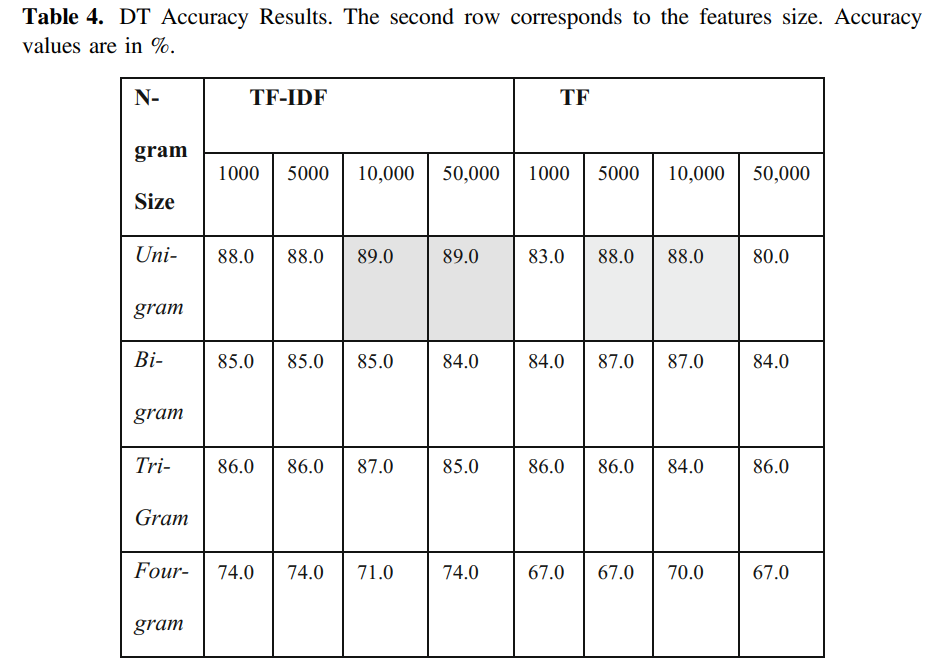

In [ ]:
# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(2, 2))
X = vectorizer.fit_transform(df_cleaned["text_stemmed"])
y = df_cleaned["fake"]

# Train a decision tree classifier using 5-fold-cross-validation
tree_model = DecisionTreeClassifier()
scores = cross_val_score(tree_model, X, y, cv=5)

# Print the cross-validation accuracy scores
print("Cross-Validation Accuracy Scores:")
for fold, score in enumerate(scores, start=1):
    print(f"Fold {fold}: {score}")
    
    
print("Average Accuracy: ", scores.mean())

In [ ]:
# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(3, 3))
X = vectorizer.fit_transform(df_cleaned["text_stemmed"])
y = df_cleaned["fake"]

# Train a decision tree classifier using 5-fold-cross-validation
tree_model = DecisionTreeClassifier()
scores = cross_val_score(tree_model, X, y, cv=5)

# Print the cross-validation accuracy scores
print("Cross-Validation Accuracy Scores:")
for fold, score in enumerate(scores, start=1):
    print(f"Fold {fold}: {score}")
    
    
print("Average Accuracy: ", scores.mean())

In [ ]:
# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(4, 4))
X = vectorizer.fit_transform(df_cleaned["text_stemmed"])
y = df_cleaned["fake"]

# Train a decision tree classifier using 5-fold-cross-validation
tree_model = DecisionTreeClassifier()
scores = cross_val_score(tree_model, X, y, cv=5)

# Print the cross-validation accuracy scores
print("Cross-Validation Accuracy Scores:")
for fold, score in enumerate(scores, start=1):
    print(f"Fold {fold}: {score}")
    
    
print("Average Accuracy: ", scores.mean())

In [ ]:
# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 4))
X = vectorizer.fit_transform(df_cleaned["text_stemmed"])
y = df_cleaned["fake"]

# Train a decision tree classifier using 5-fold-cross-validation
tree_model = DecisionTreeClassifier()
scores = cross_val_score(tree_model, X, y, cv=5)

# Print the cross-validation accuracy scores
print("Cross-Validation Accuracy Scores:")
for fold, score in enumerate(scores, start=1):
    print(f"Fold {fold}: {score}")
    
    
print("Average Accuracy: ", scores.mean())

We can now see that the accuracy declines with a heightened ngram setting. The last option is variable, where SKLEARN tries all variants and finds the best estimators.

When comparing it with the non-n-gram model, this one scores about 1 percent of mean accuracy worse, however, the maximum accuracy is just lowered by around 0.5 percent.

We can conclude that in this setting, the unigram model seems to be the way to go forward.

Comparing this to the LSVM TF-IDF model with maximum features 50 thousand, that scored 92.0 percent accuracy in the study, we got to a quite satisfying accuracy. Mentioning the fact that more modern technology and packages make this process seemingly easy.

The next main task is to illustrate the explainability that such a tree model offers. Above in the case of the reuters mistake, we could already spot one main advantage, since we can "rank" the decision points and look into reasons why this might be the case. However, suspecting that lower down values might not really make sense, we are first going to plot the decision tree in a little bigger manner, looking into possible paths.

In [ ]:
#Best Model so far!

# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df_cleaned['text_stemmed'], df_cleaned['fake'], test_size=0.2, random_state=15)

# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
train_features = vectorizer.fit_transform(train_data)
test_features = vectorizer.transform(test_data)

# Train a decision tree classifier
tree_model = DecisionTreeClassifier()
tree_model.fit(train_features, train_labels)

# Extract feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Visualize the decision tree
tree.plot_tree(tree_model, feature_names=feature_names)

# Get the most important features for classification
importance = tree_model.feature_importances_
important_features = [(feature_names[i], importance[i]) for i in range(len(feature_names))]
important_features.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 important features
print("Top 10 important features:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance}")


In [ ]:
pred = tree_model.predict(test_features)

loc_test_labels = test_labels.reset_index()
sum_correct = 0
for i in range(0, len(pred)-1):
    if pred[i] == loc_test_labels["fake"][i]:
        sum_correct += 1


sum_correct / len(pred) # 95.2% items predicted positively in total

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (30,30), dpi=600)
tree.plot_tree(tree_model, filled=True, feature_names=feature_names)
plt.savefig('tree.png', dpi=600)
plt.show()

The image "tree.png" is saved in a pretty high resolution, so one can inspect it manually. The arbitrary node annotates the word used to a path further down the tree, indicating the condition that ONE feature as a whole should hold. The child on the left hand side is chosen as a further path if the condition is held, and the left one if not. The so called "leaf node", a node with no further children, marks the final decision. The sample mark tells us how many of the train set articles did come to this point, and the value indicates how many of the samples are either fake or not.

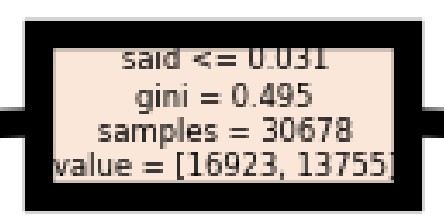

So far we do not really know what the value here means, since either fake or not fake might be first or second in this array. To find out, we can apply a technique that is used in many types of models to provide explainability, but it should hold very much value for the tree model especially. Note that we will explain what the features values can mean (TF-IDF feature).

We first talked about stop words removal and stemming. The following text already went through those.

In [ ]:
test_data[8232]

Now, feature selection, in our case, the TF-IDF measure transforms this paragraph into a sparse matrix. The study under evaluation uses the following paragraph to explain TF-IDF:

"The Term Frequency-Inverted Document Frequency (TF-IDF) is a weighting metric
often used in information retrieval and natural language processing. It is a statistical
metric used to measure how important a term is to a document in a dataset. A term
importance increases with the number of times a word appears in the document,
however, this is counteracted by the frequency of the word in the corpus.
One of the main characteristics of IDF is it weights down the term frequency while
scaling up the rare ones. For example, words such as “the” and “then” often appear in
the text, and if we only use TF, terms such as these will dominate the frequency count.
However, using IDF scales down the impact of these terms."

In [ ]:
print(test_features[0])

The index shows the relation of the keyword to the others. This can be used to establish context.

In [ ]:
tree_model.predict(test_features[0])

Above you can see what our model would predict for the sparse matrix as input - it would classify it as no fake news. (0 = real news, 1 = fake news) The IDs correspond to the feature IDs, which can be put into names (as we did in the tree model visualization)

In [ ]:
len(feature_names) #This is 5000 long because we established max_features = 5000

In [ ]:
feature_names

In [ ]:
print(tree_model.decision_path(test_features[0]))

In [ ]:
n_nodes = tree_model.tree_.node_count
children_left = tree_model.tree_.children_left
children_right = tree_model.tree_.children_right
feature = tree_model.tree_.feature
threshold = tree_model.tree_.threshold

X_test = test_features


node_indicator = tree_model.decision_path(X_test)
leaf_id = tree_model.apply(X_test)

sample_id = 2
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

This code from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
brings light into the decision path of sample 2 out of X_test. It allows us to see the path in the data.

We could now annotate this with the word corresponding to the feature and the value, but we can already see this in a better way by visualizing it again in a graph. Remember that we plotted the whole tree before, so contrasting this might be useful. We show the full graph with the nodes it passes through highlighted in a very bright color according to https://stackoverflow.com/questions/55878247/how-to-display-the-path-of-a-decision-tree-for-test-samples    (with adaptions)

We will use the same code for another sample.

In [ ]:
import pydotplus

dot_data = tree.export_graphviz(tree_model, out_file=None,
                                feature_names=feature_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

samples = X_test[514]
decision_paths = tree_model.decision_path(samples)

for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        node = graph.get_node(str(n))[0]            
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

        node.set('label', '<br/>'.join(labels))

In [ ]:
import graphviz
from IPython.display import Image
graph.write_png("decision_path_highlighted.png")
Image(graph.create_png())

You can look at the corresponding decision path under decision_path_highlighted.png, the resolution is too high for the notebook.

We found the article based on the text under: https://www.reuters.com/article/usa-trump-idUKL1N1NX1MC. It is a true article (although somewhat absurd)

In [ ]:
test_data[514]

In [ ]:
test_labels[514]

Looking at the green path we can see that we selected a sample with the probably longest path with a leaf node that indicates fake news as zero, meaning that value = [first, second] illustrates that the first is no fake news and the second one is fake news. Therefore, the model worked pretty well. Let's look at another example now.

In [ ]:
import pydotplus

dot_data = tree.export_graphviz(tree_model, out_file=None,
                                feature_names=feature_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

samples = X_test[700]
decision_paths = tree_model.decision_path(samples)

for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        node = graph.get_node(str(n))[0]            
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

        node.set('label', '<br/>'.join(labels))

In [ ]:
import graphviz
from IPython.display import Image
graph.write_png("decision_path_highlighted_2.png")
Image(graph.create_png())

In [ ]:
test_data[700]

In [ ]:
test_labels[700]

We can see that there is another path leading to another leaf node, and we can look at the path that led us there. Now, what can we do with this information? We can naively look at the path that lead us there and imply some things. Apparently, brzezinski and macron seem to play a role. The article has been identified to be fake news. Out of the training sample, 5112 samples have come down to this path. That is a big number.

But what does the number for the feature mean? The number for the feature is what our vectorizer transformed the text into, a TF-IDF measure that tries to put words into relations, where a high number indicates that there is a connection to the word in the text, but it might not even contain the word itself. Pretty abstract huh. However, it is used in practice many times. At this point, we did not figure out a way to illustrate this better than https://towardsdatascience.com/understanding-tf-idf-a-traditional-approach-to-feature-extraction-in-nlp-a5bfbe04723f#:~:text=TF%2DIDF%2C%20short%20for%20Term,in%20a%20document%20or%20corpus. did.

In essence, analysing these decision paths and looking at them can lead to the detection of linguistic cues that the model used in order to determine if it is fake news or not. At the highest level, our decision tree model relies more on the topic than the overall linguistic compilation, it seems. This might be because of selection bias in the training dataset (e.g. all articles concerning macron in the set are fake news) or other reasons. There is a way to find out, but it is very expensive! However, we argue that this way of using tree-based models to detect fake news has many potential pros, the biggest being the native explainability that tree models offer (even after applying various more complicated potential feature engineering techniques).

The ways of illustrating that we looked at seem to hold much value and come pretty much standard, without having to use advanced techniques like SHAP.

As a last task we can see two things happening:
a) build a LS-SVM model (that scored better in the study) and try to do the same explainability things we did here (maybe using SHAP or consorts) or
b) test the model on another dataset, first just predicting, then maybe also training. Compare and contrast so to say.

We decided to do option b).

## Comparison with new dataset

Since the accuracy is pretty high and the model is pretty explainable, we want to see what happens when we run it on a new dataset. We expect the accuracy to drastically drop and the explainability to be pretty random. After that, we will train it on the new dataset as well and compare and contrast.

In [ ]:
#!wget https://www.cs.ucsb.edu/~william/data/liar_dataset.zip

In [ ]:
#!unzip -o liar_dataset.zip

In [ ]:
LIAR_train = pd.read_csv('train.tsv', sep='\t', header=None)

In [ ]:
LIAR_test = pd.read_csv('test.tsv', sep='\t', header=None)

In [ ]:
LIAR = pd.concat([LIAR_train, LIAR_test])

In [ ]:
LIAR

In [ ]:
LIAR = LIAR.iloc[:, :8]

In [ ]:
LIAR.rename(columns = {0:'ID_politifact', 1:'label', 2:'statement', 3:'subjects', 4:'speaker', 5:'speakers_job_title', 6:'state_info', 7:'party_affiliation'}, inplace = True)

In [ ]:
LIAR

In [ ]:
LIAR["label"].unique()

In [ ]:
true_labels = ['true', 'half-true', 'mostly-true']

In [ ]:
LIAR["label_binary"] = LIAR["label"].apply(lambda x: 0 if x in true_labels else 1)

In [ ]:
LIAR["statement_len"] = LIAR["statement"].apply(len)

In [ ]:
LIAR["statement_len"].describe()

In [ ]:
stemmer = PorterStemmer()

LIAR["statement_stemmed"] = LIAR['statement'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [ ]:
# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(LIAR['statement_stemmed'], LIAR['label_binary'], test_size=0.2, random_state=15)

# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
train_features = vectorizer.fit_transform(train_data)
test_features = vectorizer.transform(test_data)

# Train a decision tree classifier
tree_model = DecisionTreeClassifier()
tree_model.fit(train_features, train_labels)

# Extract feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Visualize the decision tree
tree.plot_tree(tree_model, feature_names=feature_names)

# Get the most important features for classification
importance = tree_model.feature_importances_
important_features = [(feature_names[i], importance[i]) for i in range(len(feature_names))]
important_features.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 important features
print("Top 10 important features:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance}")

In [ ]:
pred = tree_model.predict(test_features)

loc_test_labels = test_labels.reset_index()
sum_correct = 0
for i in range(0, len(pred)-1):
    if pred[i] == loc_test_labels["label_binary"][i]:
        sum_correct += 1


sum_correct / len(pred) # 

The accuracy of the newly trained model is very bad. It is actually just 6% better than random. Let us now again train the best model from above and apply it to the statements.

In [ ]:
#Best Model so far!

# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df_cleaned['text_stemmed'], df_cleaned['fake'], test_size=0.2, random_state=15)

# Create a TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
train_features = vectorizer.fit_transform(train_data)
test_features = vectorizer.transform(test_data)

# Train a decision tree classifier
tree_model = DecisionTreeClassifier()
tree_model.fit(train_features, train_labels)

# Extract feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Visualize the decision tree
tree.plot_tree(tree_model, feature_names=feature_names)

# Get the most important features for classification
importance = tree_model.feature_importances_
important_features = [(feature_names[i], importance[i]) for i in range(len(feature_names))]
important_features.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 important features
print("Top 10 important features:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance}")

In [ ]:
LIAR_set = LIAR["statement_stemmed"]
LIAR_label = LIAR["label_binary"]

In [ ]:
test_features_LIAR = vectorizer.transform(LIAR_set)

In [ ]:
pred = tree_model.predict(test_features_LIAR)

loc_test_labels = LIAR_label.reset_index()
sum_correct = 0
for i in range(0, len(pred)-1):
    if pred[i] == loc_test_labels["label_binary"][i]:
        sum_correct += 1


sum_correct / len(pred) # 

You can see that the accuracy is worse than random on the shorter statements. This might have multiple reasons, e.g. because context matters more with the short statements or we have internal data bias in the dataset for the model building, ...

One would have to try out various things in order to optimize for this dataset, but this is out of scope.

We would like to continue down this path as well using bigger datasets with real news articles, for example the NELA dataset having 120GB of data, but this exceeds the efforts taken of this little project resource-wise.

Thank you for reading!